# Imports e auxiliares

In [ ]:
import os
import cv2
import math
import time
import concurrent, multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# HOG

## Extração de features

In [ ]:
def CropImages(image):
  cropped_images = []
  for i in range(6):
    reshaped = cv2.resize((image[0:50, (i*30):((i+1)*30)]), (64, 128))
    cropped_images.append(reshaped)
  return cropped_images

In [ ]:
def MagAndAngle(image):
  final_mag = []
  final_ang = []
  m, n = image.shape
  # print(m, n)
  for i in range(m):
    mag = []
    ang = []
    for j in range(n):
      if (j-1) <= 0:
        gx = (image[i][j+1])
      elif (j+1) >= n:
        gx = -(image[i][j-1])
      else:
        gx = (image[i][j+1]) - (image[i][j-1])

      if (i-1) <= 0:
        gy = -(image[i+1][j])
      elif (i+1) >= m:
        gy = (image[i-1][j])
      else:
        gy = (image[i-1][j]) - (image[i+1][j])

      curr_mag = (math.sqrt(pow(gx,2) + pow(gy,2)))
      mag.append(round(curr_mag, 9))

      if gx == 0:
        curr_ang = (math.degrees(0.0))
      else:
        curr_ang = (math.degrees(abs(math.atan(gy / gx))))
      ang.append(round(curr_ang, 9))
    final_mag.append(mag)
    final_ang.append(ang)

  return (np.array(final_mag), np.array(final_ang))

In [ ]:
def HOG(mag, ang):
  row, col = mag.shape
  features = []
  for i in range(0, row, 8):
    for j in range(0, col, 8):
      # creating moving window
      curr_mag = mag[i:i+8, j:j+8]
      curr_ang = ang[i:i+8, j:j+8]
      window_row, window_col = curr_mag.shape
      histogram = np.zeros(9)
      # sliding in the window
      for k in range(window_row):
        for l in range(window_col):
          first_bin = int(curr_ang[k, l] / 20)
          second_bin = (math.ceil(curr_ang[k, l] / 20)) % 9
          # if both bins are the same, that means that curr_ang is either 0, 20, .., 160
          if (first_bin == second_bin):
            histogram[first_bin] += curr_mag[k, l]
          # else, split accordingly
          else:
            histogram[first_bin] += curr_mag[k, l] * (1 - ((curr_ang[k, l] - first_bin*20)/20))
            histogram[second_bin] += curr_mag[k, l] * ((curr_ang[k, l] - first_bin*20)/20)
      features += histogram.tolist()
  return features

In [ ]:
def MainHog(images):
  for img_path in images:
    print(f"{len(features)} de {len(files)*6}")
    key = img_path.replace('.jpg', '')
    captcha = labels[key]

    # opening image and cropping it
    img = Image.open(f'{path}/CAPTCHA-10K/treinamento/{img_path}').convert("L")
    img = np.array(img).astype(np.float)
    cropped_imgs = CropImages(img)

    # for every cropped image, find hog feature and concatenate to feature array
    for i in range(len(cropped_imgs)):
      curr_crop = cropped_imgs[i]
      curr_char = captcha[i]

      curr_mag, curr_ang = MagAndAngle(curr_crop)
      curr_hog = HOG(curr_mag, curr_ang)
      features.append([curr_char] + curr_hog)

    os.system("clear")

In [ ]:
# fetching data
files = list(os.listdir(f"{path}/CAPTCHA-10K/treinamento"))
features = []

# isolating captchas
labels = {}
with open('labels.csv') as f:
  for line in f.read().split("\n"):
    if len(line) < 1: continue
    key, value = line.split(",")
    labels[key] = value.strip()

# using multiprocessing to execute MainHog faster
workers = multiprocessing.cpu_count()
args = np.array_split(files, workers)
with concurrent.futures.ThreadPoolExecutor(max_workers=workers) as executor:
  futures = [executor.submit(MainHog, arg) for arg in args]
  concurrent.futures.wait(futures)

df = pd.DataFrame(features)
df.to_csv("treinamento.csv")

FileNotFoundError: ignored

## Classificação

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
def Datasets():
    # fetching train data
    df_train = pd.read_csv('train.csv', index_col=[0])
    X_train = df_train.drop('0', axis=1)
    y_train = df_train['0'].values

    # treating labels
    labels = sorted(set(y_train))
    dict_transform = {label: i for i, label in enumerate(labels)}

    # znormalizing train data
    y_train = np.array([dict_transform[v] for v in y_train])
    X_train = (X_train - X_train.mean()) / X_train.std()
    X_train = X_train.replace(np.nan, 0)

    # fetching test data
    df_test = pd.read_csv('test.csv', index_col=[0])
    X_test = df_test.drop('0', axis=1)
    y_test = df_test['0'].values

    # znormalizing test data
    y_test = np.array([dict_transform[v] for v in y_test])
    X_test = (X_test - X_test.mean()) / X_test.std()
    X_test = X_test.replace(np.nan, 0)

    # fetching validation data
    df_validation = pd.read_csv('validation.csv', index_col=[0])
    X_validation = df_validation.drop('0', axis=1)
    y_validation = df_validation['0'].values

    # znormalizing validation data
    y_validation = np.array([dict_transform[v] for v in y_validation])
    X_validation = (X_validation - X_validation.mean()) / X_validation.std()
    X_validation = X_validation.replace(np.nan, 0)

    return X_train.values, y_train, X_test.values, y_test, X_validation.values, y_validation, dict_transform

In [ ]:
def TrainModels(X_train, y_train, X_test, y_test, dict):
    # chosing models to test/train
    models = {
        # 'Logistic Regression': LogisticRegression(random_state = 42, max_iter = 1500, solver='newton-cg', penalty='l2'),
        # 'KNN': KNeighborsClassifier(n_neighbors = 10, weights='distance',algorithm='kd_tree', metric='minkowski', p=1),
        # 'Random Forest': RandomForestClassifier(criterion = 'gini',n_estimators = 50, random_state = 42),
        # 'Decision Tree': DecisionTreeClassifier(criterion = 'gini', random_state = 42),
        'SVM': SVC(random_state = 42),
        # 'SGDC': SGDClassifier(loss='perceptron', random_state=42)
    }
    os.system('clear')
    # for each one of them, execute the classifier and fetch the accuracies
    for label, model in models.items():
        print(f'Current classifier: {label}')
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        print(f'Train accuracy: {np.round(accuracy_score(y_train,y_train_pred),4)}')
        print(f'Test accuracy: {np.round(accuracy_score(y_test,y_test_pred),4)}\n')

        dict_values = list(dict.values())
        dict_keys = list(dict.keys())

        f = open('test.txt', 'w')
        i = 1
        curr = ''
        for acc in y_test:
            curr_pos = dict_values.index(acc)
            curr += str(dict_keys[curr_pos])
            if i == 6:
                f.write(curr+'\n')
                i = 1
                curr = ''
            else:
                i = i + 1

        f = open('test_pred.txt', 'w')
        i = 1
        curr = ''
        for pred in y_test_pred:
            curr_pos = dict_values.index(pred)
            curr += str(dict_keys[curr_pos])
            if i == 6:
                f.write(curr+'\n')
                i = 1
                curr = ''
            else:
                i = i + 1


In [ ]:
X_train, y_train, X_test, y_test, X_validation, y_validation, dict = Datasets()
TrainModels(X_train, y_train, X_test, y_test, dict)

{1: 0.999, 2: 0.999, 3: 0.988, 4: 0.931, 5: 0.729, 6: 0.322}


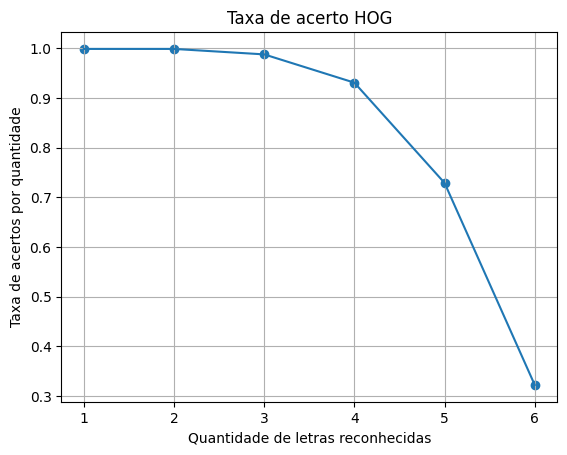

In [ ]:
truth = []
with open('test.txt') as f:
  for line in f.read().split("\n"):
    if len(line) < 1: continue
    truth.append(line)

pred = []
with open('test_pred.txt') as f:
  for line in f.read().split("\n"):
    if len(line) < 1: continue
    pred.append(line)

hits = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
curr_pos = 1
for i in range(len(pred)):
  for j in range(len(pred[i])):
    if(pred[i][j] == truth[i][j]):
      hits[curr_pos] += 1
      curr_pos += 1
  curr_pos = 1

for i in range(1,7):
  hits[i] /= 1000

print(hits)
keys = hits.keys()
values = hits.values()
plt.scatter(keys,values)
plt.plot(keys,values)
plt.grid()
plt.xlabel("Quantidade de letras reconhecidas")
plt.ylabel("Taxa de acertos por quantidade")
plt.title("Taxa de acerto HOG")
plt.show()

# Testes

<ipython-input-5-7f4f2d87f80b>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = np.array(img).astype(np.float)


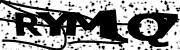

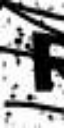

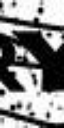

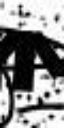

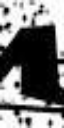

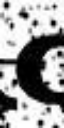

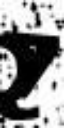

In [ ]:
img = Image.open('009007.jpg').convert("L")
img = np.array(img).astype(np.float)
cv2_imshow(img)
cropped_imgs = CropImages(img)
for crop in cropped_imgs:
  cv2_imshow(crop)

<ipython-input-73-3f85e625d2c4>:17: RuntimeWarning: overflow encountered in ubyte_scalars
  Gx = image[i][j+1] - image[i][j-1]
<ipython-input-73-3f85e625d2c4>:26: RuntimeWarning: overflow encountered in ubyte_scalars
  Gy = image[i-1][j] - image[i+1][j]


(128, 64)


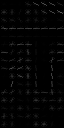

In [ ]:
def Test(image):
  mag = []
  theta = []
  for i in range(128):
    magnitudeArray = []
    angleArray = []
    for j in range(64):
      # Condition for axis 0
      if j-1 <= 0 or j+1 >= 64:
        if j-1 <= 0:
          # Condition if first element
          Gx = image[i][j+1] - 0
        elif j + 1 >= len(image[0]):
          Gx = 0 - image[i][j-1]
      # Condition for first element
      else:
        Gx = image[i][j+1] - image[i][j-1]

      # Condition for axis 1
      if i-1 <= 0 or i+1 >= 128:
        if i-1 <= 0:
          Gy = 0 - image[i+1][j]
        elif i +1 >= 128:
          Gy = image[i-1][j] - 0
      else:
        Gy = image[i-1][j] - image[i+1][j]

      # Calculating magnitude
      magnitude = math.sqrt(pow(Gx, 2) + pow(Gy, 2))
      magnitudeArray.append(round(magnitude, 9))

      # Calculating angle
      if Gx == 0:
        angle = math.degrees(0.0)
      else:
        angle = math.degrees(abs(math.atan(Gy / Gx)))
      angleArray.append(round(angle, 9))
    mag.append(magnitudeArray)
    theta.append(angleArray)

  mag = np.array(mag)
  theta = np.array(theta)
  return mag, theta

from skimage.feature import hog

t = Image.open('CAPTCHA-10K/treinamento/000002.jpg').convert('L')
t = np.array(t)
a = cv2.resize(t[0:50,0:30], (64, 128))
# cv2_imshow(a)

# print(t)
mag, ang = MagAndAngle(a)
# cv2_imshow(mag)
# cv2_imshow(ang)

mag, ang = Test(a)
# cv2_imshow(mag)
# cv2_imshow(ang)

t = Image.open('CAPTCHA-10K/treinamento/000005.jpg').convert('L')
t = np.array(t)
a = cv2.resize(t[0:50,60:90], (64, 128))
# cv2_imshow(a)

# print(t)
mag, ang = MagAndAngle(a)
# cv2_imshow(mag)
# cv2_imshow(ang)

mag, ang = Test(a)
# cv2_imshow(mag)
# cv2_imshow(ang)

print(a.shape)
fd, hog_image = hog(a, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True)
cv2_imshow(hog_image)

<ipython-input-72-ebbe780bc741>:85: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  t = np.array(t).astype(np.float)


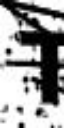

(128, 64) (128, 64)


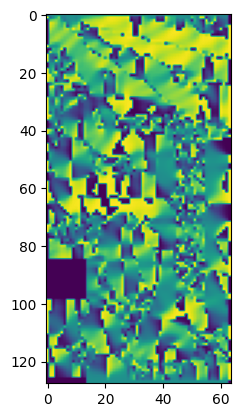

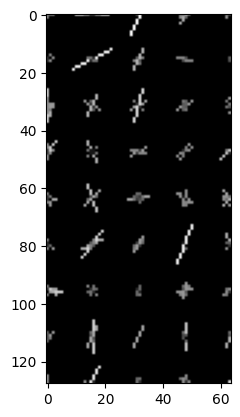

(3780,)


In [ ]:
def render_gradient( image, cell_gradient):
    cell_size  = 16
    bin_size = 9
    angle_unit = 180// bin_size
    cell_width =  cell_size / 2
    max_mag = np.array(cell_gradient).max()
    for x in range(cell_gradient.shape[0]):
        for y in range(cell_gradient.shape[1]):
            cell_grad = cell_gradient[x][y]
            cell_grad /= max_mag
            angle = 0
            angle_gap = angle_unit
            for magnitude in cell_grad:
                angle_radian = math.radians(angle)
                x1 = int(x * cell_size + magnitude * cell_width * math.cos(angle_radian))
                y1 = int(y * cell_size + magnitude * cell_width * math.sin(angle_radian))
                x2 = int(x * cell_size - magnitude * cell_width * math.cos(angle_radian))
                y2 = int(y * cell_size - magnitude * cell_width * math.sin(angle_radian))
                cv2.line(image, (y1, x1), (y2, x2), int(255 * math.sqrt(abs(magnitude))))
                angle += angle_gap
    return image

def div(img, cell_x, cell_y, cell_w):
    cell = np.zeros(shape=(cell_x, cell_y, cell_w, cell_w))
    img_x = np.split(img, cell_x , axis=0)
    for i in range(cell_x):
        img_y = np.split(img_x[i], cell_y, axis=1)
        for j in range(cell_y):
            cell[i][j] = img_y[j]
    return cell

# Get the gradient direction histogram image, each pixel has 9 values
def get_bins(grad_cell, ang_cell):
    bins = np.zeros(shape=(grad_cell.shape[0], grad_cell.shape[1], 9))
    for i in range(grad_cell.shape[0]):
        for j in range(grad_cell.shape[1]):
            binn = np.zeros(9)
            grad_list = np.int8(grad_cell[i, j].flatten())  # .flatten() is a dimensionality reduction function, which reduces the dimensionality to one dimension, the 64 gradient values ​​in each cell are flattened and converted to integers
            ang_list = ang_cell[i, j].flatten()  # Flatten the 64 gradient directions in each cell
            ang_list = np.int8(ang_list / 20.0)  # 0-9
            ang_list[ang_list >= 9] = 0
            for m in range(len(ang_list)):
                binn[ang_list[m]] += int(grad_list[m])  # Amplitude of histogram
            bins[i][j] = binn

    return bins

# Calculate the image HOG feature vector and display
def hog(img, cell_x, cell_y, cell_w):
    gradient_values_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)  # x
    gradient_values_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)  # y
    gradient_magnitude = np.sqrt(np.power(gradient_values_x, 2) + np.power(gradient_values_y, 2))
    gradient_angle = np.arctan2(gradient_values_x, gradient_values_y)
    print(gradient_magnitude.shape, gradient_angle.shape)
    gradient_angle[gradient_angle > 0] *= 180 / 3.14
    gradient_angle[gradient_angle < 0] = (gradient_angle[gradient_angle < 0] + 3.14) * 180 / 3.14
    # plt.imshow() is based on the size of the image, showing the current gradient direction value calculated for each pixel
    # plt.imshow(gradient_magnitude) #Display the gradient value of the image
    plt.imshow(gradient_angle ) #Display the gradient direction value of the image
    # Only one value of the gradient size and direction of the image can be displayed. If plt.imshow() is to be displayed at the same time, it needs to be partitioned.
    plt.show()
    grad_cell = div(gradient_magnitude, cell_x, cell_y, cell_w)
    ang_cell = div(gradient_angle, cell_x, cell_y, cell_w)
    bins = get_bins(grad_cell, ang_cell)
    hog_image = render_gradient(np.zeros([img.shape[0], img.shape[1]]), bins)
    plt.imshow(hog_image, cmap=plt.cm.gray)
    plt.show()
    feature = []
    for i in range(cell_x - 1):
        for j in range(cell_y - 1):
            tmp = []
            tmp.append(bins[i, j])
            tmp.append(bins[i + 1, j])
            tmp.append(bins[i, j + 1])
            tmp.append(bins[i + 1, j + 1])
            tmp -= np.mean(tmp)
            feature.append(tmp.flatten())
    return np.array(feature).flatten()

def gamma(img):
    return np.power(img / 255.0, 1)

cell_w = 8
t = Image.open('CAPTCHA-10K/treinamento/000002.jpg').convert('L')
t = np.array(t).astype(np.float)
img = cv2.resize(t[0:50,0:30], (64, 128))
# img = cv2.imread('3.png', cv2.IMREAD_GRAYSCALE)
# print(img.shape)
x = img.shape[0] - img.shape[0] % cell_w #Find the number closest to the original image row value divisible by 8
y = img.shape[1] - img.shape[1] % cell_w #Find the number closest to the original image column value divisible by 8
resizeimg = cv2.resize(img, (y, x), interpolation=cv2.INTER_CUBIC)
cv2_imshow(resizeimg)
cell_x = int(resizeimg.shape[0] // cell_w)  # cell line number
cell_y = int(resizeimg.shape[1] // cell_w)  # cell column number
gammaimg = gamma(resizeimg) * 255
feature = hog(gammaimg, cell_x, cell_y, cell_w)
print(feature.shape)

In [ ]:
# Cálculo do j-ésimo bin
def CalculateJIdx(angle):
  temp = (angle / 20) - 0.5
  j = math.floor(temp)
  return j

# Cálculo do valor de centro do j-ésimo bin
def CalculateJCenter(j):
  Cj = 20 * (j + 0.5)
  return round(Cj, 9)

# Cálculo do valor do j-ésimo bin
def CalculateJValue(magnitude, angle, j):
  Cj = CalculateJCenter(j+1)
  Vj = magnitude * ((Cj - angle) / 20)
  return round(Vj, 9)

def HOG(mag, ang):
  histogram = []
  for i in range(0, 128, 8):
    temp = []
    for j in range(0, 64, 8):
      magnitude_values = [[mag[i][x] for x in range(j, j+8)] for i in range(i,i+8)]
      angle_values = [[ang[i][x] for x in range(j, j+8)] for i in range(i, i+8)]
      for k in range(len(magnitude_values)):
        for l in range(len(magnitude_values[0])):
          bins = [0.0 for _ in range(9)]
          j_idx = CalculateJIdx(angle_values[k][l])
          j_value = CalculateJValue(magnitude_values[k][l], angle_values[k][l], j_idx)
          j_value_1 = magnitude_values[k][l] - j_value
          bins[j_idx]+=j_value
          bins[j_idx+1]+=j_value_1
          bins = [round(x, 9) for x in bins]
      temp.append(bins)
    histogram.append(temp)
  feature_vectors = []
  epsilon = 1e-05
  for i in range(0, len(histogram) - 1, 1):
    temp = []
    for j in range(0, len(histogram[0]) - 1, 1):
      values = [[histogram[i][x] for x in range(j, j+2)] for i in range(i, i+2)]
      final_vector = []
      for k in values:
        for l in k:
          for m in l:
            final_vector.append(m)
      k = round(math.sqrt(sum([pow(x, 2) for x in final_vector])), 9)
      final_vector = [round(x/(k + epsilon), 9) for x in final_vector]
      temp.append(final_vector)
    feature_vectors.append(temp)
  return feature_vectors

#CNN

In [ ]:
#import for cnn
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [ ]:
def CropImagesCNN(image):
  cropped_images = []
  for i in range(6):
    reshaped = (image[0:50, (i*30):((i+1)*30)])
    cropped_images.append(reshaped)
  return cropped_images

In [ ]:
def read_crop_df(path, labels_dict):
  files_teste = list(os.listdir(path)) #list of imgs for test
  list_of_cropps = [] #list of letters cropped from captcha
  label_of_cropps = [] #list of labbels for each letter cropped
  for img_path in files_teste:
    img_test = Image.open(f'{path}/{img_path}').convert("L") #reading img from file
    img_test = np.array(img_test).astype('float32') #converting to uint8 (0-255 range)
    key = img_path.replace('.jpg', '')
    captcha = labels_dict[key]
    cropped_ver = CropImagesCNN(img_test) ##cropped version of captcha
    for i in range(len(cropped_ver)):
      label_of_cropps.append(captcha[i])
      list_of_cropps.append(cropped_ver[i])

  return_matrix = np.array(list_of_cropps)
  return_y_vector = np.array(label_of_cropps)
  return return_matrix, return_y_vector

In [ ]:
def get_dict_labels(label_path):
  labels = {}
  with open(label_path) as f:
    for line in f.read().split("\n"):
      if len(line) < 1: continue
      key, value = line.split(",")
      labels[key] = value.strip()
  return labels

In [ ]:
def letters_for_numbers(vector_y):
  label_indexed = {
    "0": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5,
    "6": 6,
    "7": 7,
    "8": 8,
    "9": 9,
    "?": 10,
    "A": 11,
    "B": 12,
    "C": 13,
    "D": 14,
    "E": 15,
    "F": 16,
    "G": 17,
    "H": 18,
    "I": 19,
    "J": 20,
    "K": 21,
    "L": 22,
    "M": 23,
    "N": 24,
    "O": 25,
    "P": 26,
    "Q": 27,
    "R": 28,
    "S": 29,
    "T": 30,
    "U": 31,
    "V": 32,
    "W": 33,
    "X": 34,
    "Y": 35,
    "Z": 36
  }
  return np.array([label_indexed[v] for v in vector_y])

In [ ]:
def reshaper_and_normalizer_for_X(X_data):
  X_data_copy = X_data
  X_data_copy = X_data_copy.reshape(X_data_copy.shape[0], 50, 30, 1)
  print(X_data_copy.shape)
  X_data_copy /= 255
  return X_data_copy

In [ ]:
def normalizer_for_Y(Y_data):
  converted_Y_data = letters_for_numbers(Y_data)
  return converted_Y_data

In [ ]:
def get_complete_data(pth, l_pth):
  pth_to_use = pth
  l_pth_to_use = l_pth

  dictionary_of_labels = get_dict_labels(l_pth_to_use)

  X_dt, y_dt = read_crop_df(pth_to_use, dictionary_of_labels)
  print(X_dt.shape)
  print(y_dt.shape)

  X_dt_c = reshaper_and_normalizer_for_X(X_dt)
  y_dt_c = normalizer_for_Y(y_dt)

  return X_dt_c, y_dt_c

In [ ]:
#Define this!!!!
label_path = '/content/drive/MyDrive/CAPTCHA-10k/labels.csv' #diretorio contendo o csv para fazer o dicionario de labels

In [ ]:
#Reading de X and Y matrix for the TRAIN SET.

path_train = '/content/drive/MyDrive/CAPTCHA-10k/treinamento' #diretório contendo a pasta com os dados de treino (imgs)
X_train, y_train = get_complete_data(path_train, label_path)

(48000, 50, 30)
(48000,)
(48000, 50, 30, 1)


In [ ]:
#Doing the X and Y matrix for the VALIDATION SET.
path_valid = '/content/drive/MyDrive/CAPTCHA-10k/validacao'
X_valid, y_valid = get_complete_data(path_valid, label_path)

(6000, 50, 30)
(6000,)
(6000, 50, 30, 1)


In [ ]:
##Doing the X and Y matrix for TEST SET.
path_test = '/content/drive/MyDrive/CAPTCHA-10k/teste' #path with test
X_test, y_test = get_complete_data(path_test, label_path)

(6000, 50, 30)
(6000,)
(6000, 50, 30, 1)


##Modeling the CNN properly

In [ ]:
#Sequential layers
model = models.Sequential() ##Initializing the model for CNN

In [ ]:
#Input Layer
model.add(layers.Conv2D(32, (5,5), strides=(1,1), activation='relu', padding='same', input_shape=(50,30,1)))

In [ ]:
#Hidden Layers
model.add(layers.Conv2D(32, (5,5), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(layers.Conv2D(32, (5,5), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(layers.Dropout(0.20))
model.add(layers.Conv2D(32, (5,5), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.20))

In [ ]:
#Fully connected / Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(150, activation='relu'))
model.add(layers.Dense(37, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 50, 30, 32)        832       
                                                                 
 conv2d_33 (Conv2D)          (None, 50, 30, 32)        25632     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 25, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 25, 15, 32)        25632     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 13, 8, 32)         0         
 ng2D)                                                           
                                                                 
 dropout_11 (Dropout)        (None, 13, 8, 32)        

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
print(y_train)
print(y_train.shape)

[35 24 17 ... 21  1 28]
(48000,)


In [ ]:
print(y_valid)
print(y_valid.shape)

[26 32  2 ... 35 12  9]
(6000,)


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=128, epochs=5)

Epoch 1/5
375/375 [==============================] - 551s 1s/step - loss: 1.2017 - accuracy: 0.6365 - val_loss: 0.3503 - val_accuracy: 0.8788
Epoch 2/5
375/375 [==============================] - 551s 1s/step - loss: 0.3373 - accuracy: 0.8907 - val_loss: 0.2240 - val_accuracy: 0.9213
Epoch 3/5
375/375 [==============================] - 554s 1s/step - loss: 0.2701 - accuracy: 0.9108 - val_loss: 0.2224 - val_accuracy: 0.9245
Epoch 4/5
375/375 [==============================] - 553s 1s/step - loss: 0.2353 - accuracy: 0.9220 - val_loss: 0.1870 - val_accuracy: 0.9343
Epoch 5/5
375/375 [==============================] - 546s 1s/step - loss: 0.2144 - accuracy: 0.9289 - val_loss: 0.1742 - val_accuracy: 0.9423


In [ ]:
model.evaluate(X_test, y_test)

188/188 [==============================] - 18s 96ms/step - loss: 0.1828 - accuracy: 0.9398


[0.18280591070652008, 0.9398333430290222]

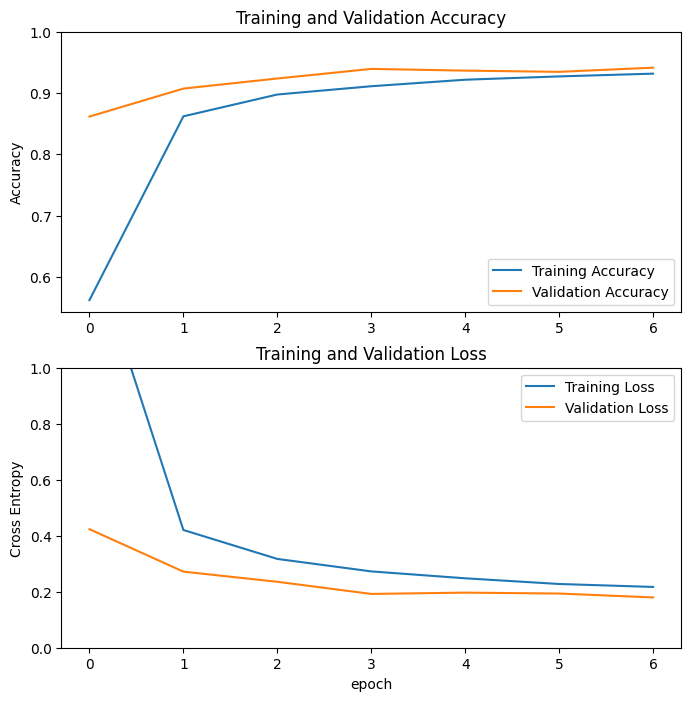

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predicted_values = model.predict(X_test)

188/188 [==============================] - 19s 98ms/step


In [ ]:
print(predicted_values.shape)
print(np.round(predicted_values[2]))

(6000, 37)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
def transforming_onehot_to_letters(y_pred):
  without_encoding = []
  for i in range(len(y_pred)):
    without_encoding.append(np.argmax(y_pred[i]))
  array_version = np.array(without_encoding)
  return array_version

In [ ]:
y_pred_without_encoding = transforming_onehot_to_letters(predicted_values)
print(y_test)
print(y_pred_without_encoding)

[ 6  1  5 ... 11 26 28]
[ 6  1  5 ... 11 26 28]


In [ ]:
y_test_captchas = y_test.reshape(1000,6)
y_pred_captchas = y_pred_without_encoding.reshape(1000,6)

In [ ]:
def calculating_probability_of_hits(teste, predicao):

  hits_cnn = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
  actual_position = 1
  for i in range(len(predicao)):
    for j in range(len(predicao[i])):
      if(predicao[i][j] == teste[i][j]):
        hits_cnn[actual_position] += 1
        actual_position += 1
    actual_position = 1

  for i in range(1,7):
    hits_cnn[i] /= 1000

  return hits_cnn

In [ ]:
results = calculating_probability_of_hits(y_test_captchas, y_pred_captchas)

{1: 1.0, 2: 1.0, 3: 1.0, 4: 0.999, 5: 0.958, 6: 0.707}

{1: 1.0, 2: 1.0, 3: 1.0, 4: 0.999, 5: 0.958, 6: 0.707}


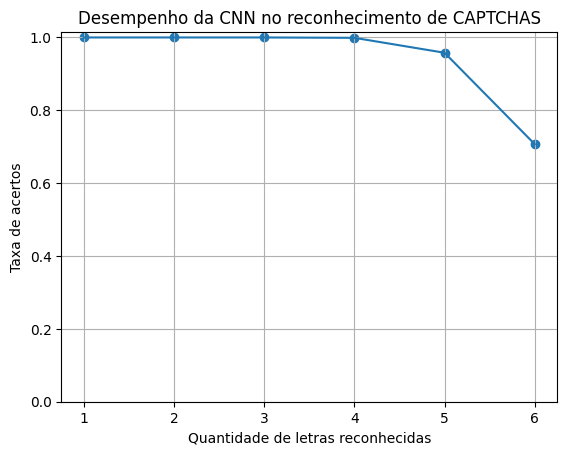

In [ ]:
print(results)
cnn_keys = results.keys()
cnn_values = results.values()
plt.scatter(cnn_keys,cnn_values)
plt.plot(cnn_keys,cnn_values)
plt.grid()
plt.xlabel("Quantidade de letras reconhecidas")
plt.ylabel("Taxa de acertos")
plt.title("Desempenho da CNN no reconhecimento de CAPTCHAS")
plt.ylim(0)
plt.show()